<a href="https://colab.research.google.com/github/Jordan-mackey/python_projects/blob/main/LSTM_APPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# For timeseries RNN LSTM neural network
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [ ]:
# import Keras: Timeseries Generator 
# This class produces time series batches used on training/testing the model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# import MinMaxScaler
# This class is used to preprocess (scale) the data
from sklearn.preprocessing import MinMaxScaler

# Dataset: AAPL (01/01/2014 - 02/18/2022)

In [ ]:
dir_path_dataset_1 = 'DATA/AAPL.csv'

### Load Dataset into DataFrame

In [ ]:
df_ALL = pd.read_csv(dir_path_dataset_1)

In [ ]:
df_ALL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.494318,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,17.110039,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.203346,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,17.080307,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,17.188478,258529600


# Brief EDA

In [ ]:
df_ALL.shape

(2049, 7)

In [ ]:
df_ALL.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
# Statistical summary
df_ALL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2.049000e+03
mean,58.460144,59.080064,57.858505,58.494184,56.870121,1.513949e+08
std,42.088815,42.597094,41.580848,42.107121,42.692927,8.581324e+07
min,17.684999,17.911785,17.626785,17.849285,15.806974,4.100000e+07
25%,28.365000,28.590000,28.077499,28.372499,26.134121,9.431800e+07
50%,41.952499,42.522499,41.610001,42.084999,40.359653,1.280424e+08
75%,70.275002,71.222504,69.639999,70.742500,69.783585,1.838572e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,1.065523e+09


# Keep only "Close" for Closing Price, and Filter Out All Others

### Research focuses only on the closing price

In [ ]:
df = df_ALL.iloc[:, 4:5]

In [ ]:
df.head()

,Close
0,19.754642
1,19.320715
2,19.426071
3,19.287144
4,19.409286


<AxesSubplot:>

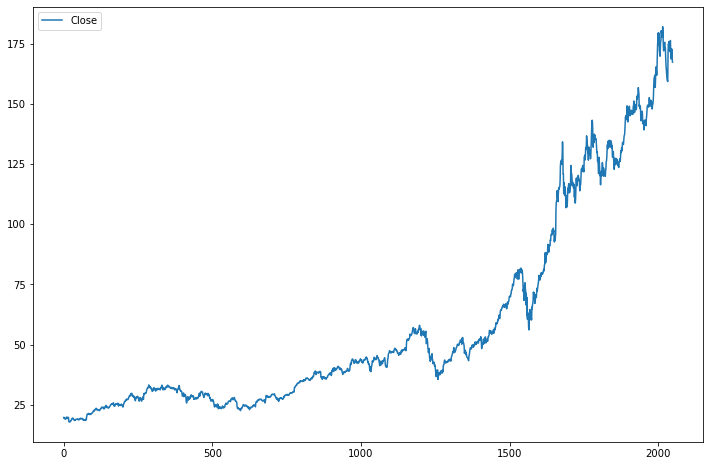

In [ ]:
df.plot(figsize = (12,8))

## Length of Input Timeseries - Number of Input Time Steps

In [3]:
# Set the length of the input sequence
# i.e, the number of timeseries steps that are used to predict the future one
# currently use 60 historical data points to predict the next one
# means that 60 consecutive closing prices will be used to predict the next one
length60 = 60

In [4]:
length60

60

# Timeseries Dataset: Train/Test Split

In [ ]:
len(df)

2049

In [ ]:
# Set percentage of data used for testing
test_percent = 0.1

In [ ]:
# Number of data points reserved for testing the model
# 10% of the original dataset

len(df)*test_percent

204.9

## Split Data --> Train/Test

In [ ]:
# Need to find the length of the testing dataset
# It has been found above that around 205 data points are used for testing

test_length = np.round(len(df)*test_percent)

test_length

205.0

In [ ]:
# Find index of the sequence where the testing data starts
# test_start_index = int(len(df) - test_length)
split_index = int(len(df) - test_length)

split_index

1844

In [ ]:
# Create separate training and testing datasets

# Training dataset: all indices from start to split_index
# excluding split_index
data_train = df.iloc[:split_index]

# Testing dataset:
# --) all the indices from (split_index - length60) to the end of the DF
# --) split_index - length60: need the last 60 historical data points (also belong to data_train)
#     to predict the first data point of the data_test
data_test = df.iloc[split_index - length60 :]

In [ ]:
data_train.head(5)

,Close
0,19.754642
1,19.320715
2,19.426071
3,19.287144
4,19.409286


In [ ]:
data_train.tail()

,Close
1839,134.320007
1840,134.720001
1841,134.389999
1842,133.580002
1843,133.479996


In [ ]:
data_test.head()

,Close
1784,133.940002
1785,137.389999
1786,136.759995
1787,136.910004
1788,136.009995


data_test.tail()

# Normalize the Data (Scaled to Range [0, 1])

In [ ]:
# Create a MinMaxScaler to normalize the data
scaler = MinMaxScaler()

In [ ]:
# Ignore the warning: just converting the data to floats
# only scale the training data, not scaling the testing data

# Train the scaler to perform the normalization
scaler.fit(data_train)

MinMaxScaler()

In [ ]:
# Normalize the training dataset
normalized_train = scaler.transform(data_train)

# Normalize the testing dataset
normalized_test = scaler.transform(data_test)

## Create TimeseriesGenerator for Training

In [ ]:
# TimeseriesGenerator: Generate time series batches for training/testing

# Set the length of the input sequence as above
# length60

# batch_size: the number of time series samples in each batch
# Sample: a single time series input that has 60 historical data points
batch_size32 = 32

# Create a TimeseriesGenerator for training: train_tsGenerator
# --) This time series generator produces time serires batches used to train the model
# TimeseriesGenerator(inputs, outputs, length, batch_size)
# --) Normally: INPUTS & OUTPUTS are the same dataset during training & testing/validation

train_tsGenerator60 = TimeseriesGenerator(normalized_train, normalized_train, length = length60, batch_size = batch_size32)

In [ ]:
len(normalized_train)

1844

In [ ]:
len(train_tsGenerator60)

56

In [ ]:
# What does the first batch look like?
X,y = train_tsGenerator60[0]

In [ ]:
print(X)

[[[0.01520506]
  [0.01174225]
  [0.01258301]
  ...
  [0.01140024]
  [0.01073903]
  [0.01056802]]

 [[0.01174225]
  [0.01258301]
  [0.01147435]
  ...
  [0.01073903]
  [0.01056802]
  [0.01053383]]

 [[0.01258301]
  [0.01147435]
  [0.01244906]
  ...
  [0.01056802]
  [0.01053383]
  [0.0119332 ]]

 ...

 [[0.01272553]
  [0.0126001 ]
  [0.01317013]
  ...
  [0.02637729]
  [0.02514037]
  [0.02444211]]

 [[0.0126001 ]
  [0.01317013]
  [0.01071338]
  ...
  [0.02514037]
  [0.02444211]
  [0.02651981]]

 [[0.01317013]
  [0.01071338]
  [0.00894064]
  ...
  [0.02444211]
  [0.02651981]
  [0.02678484]]]


In [ ]:
print(y)

[[0.01053383]
 [0.0119332 ]
 [0.0121897 ]
 [0.01111808]
 [0.00913158]
 [0.00675178]
 [0.00674325]
 [0.00870409]
 [0.00675465]
 [0.00565168]
 [0.00624164]
 [0.00518141]
 [0.00548067]
 [0.00717074]
 [0.00894635]
 [0.00909739]
 [0.00711661]
 [0.01937755]
 [0.02056604]
 [0.02687891]
 [0.02637729]
 [0.02573888]
 [0.02613505]
 [0.02644854]
 [0.02883689]
 [0.02697012]
 [0.02637729]
 [0.02514037]
 [0.02444211]
 [0.02651981]
 [0.02678484]
 [0.0268162 ]]


# Build, Train, Test Model

### Build LSTM Model

In [ ]:
# Set number of features

# Only using the one feature: close price
n_features = 1

In [ ]:
# Define the model
model = Sequential()

# Add an LSTM layer
# This layer has 50 LSTM cells
# Activiation function: relu
# Must: return_sequences = True
# --) because of mulitple LSTM layers, the layers are stacked
# --) outputs = inputs of the next LSTM layer
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (length60, n_features)))

# Dropout Layer
model.add(Dropout(0.2))

# Add 2nd LSTM layer
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True))

# Dropout Layer 
model.add(Dropout(0.2))

# Add 3rd LSTM layer
model.add(LSTM(units = 50, activation = 'relu'))

# Add a FC (fully connected) layer
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Compile the Model

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
____________________________________________________

### Train (Fit) the Model Using fit_generator()

In [ ]:
# Train the model

model.fit_generator(train_tsGenerator60, epochs = 50)

Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=8

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_IN

56/56 [==============================] - 34s 614ms/step - loss: 0.0472
Epoch 2/50
56/56 [==============================] - 26s 473ms/step - loss: 0.0178
Epoch 3/50
56/56 [==============================] - 27s 480ms/step - loss: 0.0311
Epoch 4/50
56/56 [==============================] - 26s 465ms/step - loss: 0.0288
Epoch 5/50
56/56 [==============================] - 27s 488ms/step - loss: 0.0395
Epoch 6/50
56/56 [==============================] - 27s 485ms/step - loss: 0.0103
Epoch 7/50
56/56 [==============================] - 27s 482ms/step - loss: 0.0024
Epoch 8/50
56/56 [==============================] - 26s 463ms/step - loss: 0.0013
Epoch 9/50
56/56 [==============================] - 27s 478ms/step - loss: 0.0016
Epoch 10/50
56/56 [==============================] - 26s 461ms/step - loss: 0.0010
Epoch 11/50
56/56 [==============================] - 25s 453ms/step - loss: 0.0014
Epoch 12/50
56/56 [==============================] - 27s 474ms/step - loss: 0.0013
Epoch 13/50
56/56 [=====

# Visualize Model's Performance after Training

In [ ]:
loss_history_keys = model.history.history.keys()

# model.history.history is a dict
# 'loss' is its key
# 'loss' is the loss during training
loss_history_keys

dict_keys(['loss'])

<AxesSubplot:>

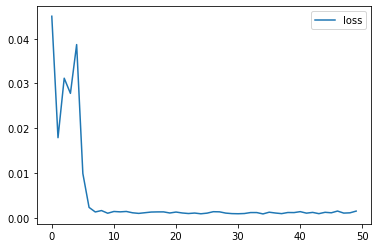

In [ ]:
# load the loss data (model.history.history) into a dataframe
df_model_loss = pd.DataFrame(model.history.history)

# Visualize the loss data using DataFrame.plot()
df_model_loss.plot()

# Prediction for Testing: Using Timeseries Generator

### Create Timeseries Generator for Testing

In [ ]:
# batch_size MUST be 1
batch_size1 = 1

# Create a TimeseriesGenerator for testing: test_tsGenerator for testing: test_tsGenerator
test_tsGenerator60 = TimeseriesGenerator(normalized_test, normalized_test, length = length60, batch_size = batch_size1)

### Predict Future Data Points for Testing


In [ ]:
normalized_prediction = model.predict_generator (test_tsGenerator60)

In [ ]:
# prediction is a numpy 2D array with only one column
normalized_prediction

array([[0.87816966],
       [0.87988514],
       [0.8812126 ],
       [0.88187253],
       [0.8818637 ],
       [0.8813868 ],
       [0.8806264 ],
       [0.8794731 ],
       [0.8778915 ],
       [0.8755724 ],
       [0.8728018 ],
       [0.8700386 ],
       [0.8673682 ],
       [0.8647224 ],
       [0.8621066 ],
       [0.8598295 ],
       [0.85778147],
       [0.85608184],
       [0.854709  ],
       [0.8536289 ],
       [0.8526858 ],
       [0.85174835],
       [0.85073745],
       [0.84971356],
       [0.8485592 ],
       [0.8475112 ],
       [0.8466341 ],
       [0.84601057],
       [0.8456669 ],
       [0.8455088 ],
       [0.8455652 ],
       [0.84603965],
       [0.8468864 ],
       [0.8480672 ],
       [0.84962267],
       [0.85139763],
       [0.85341144],
       [0.855729  ],
       [0.85828304],
       [0.8609626 ],
       [0.8636476 ],
       [0.86637366],
       [0.86922276],
       [0.8722211 ],
       [0.87534535],
       [0.8787225 ],
       [0.88246757],
       [0.886

In [ ]:
len(normalized_prediction)

205

In [ ]:
# Convert normalized predictions back to the true values

prediction = scaler.inverse_transform(normalized_prediction)

In [ ]:
# Flatten all the 2D array

# data_train = data_train.reshape((-1))
# data_test = data_test.reshape((-1))
# prediction = prediction.reshape((-1))

prediction_index = np.arange(1844, 2049, step = 1)

df_prediction = pd.DataFrame(data = prediction, index = prediction_index, columns = ['Prediction'])

In [ ]:
df_prediction 

,Prediction
1844,127.893356
1845,128.108337
1846,128.274673
1847,128.357361
1848,128.356262
...,...
2044,156.999542
2045,157.181793
2046,157.334045
2047,157.468231


### Visualize Predictions

<AxesSubplot:>

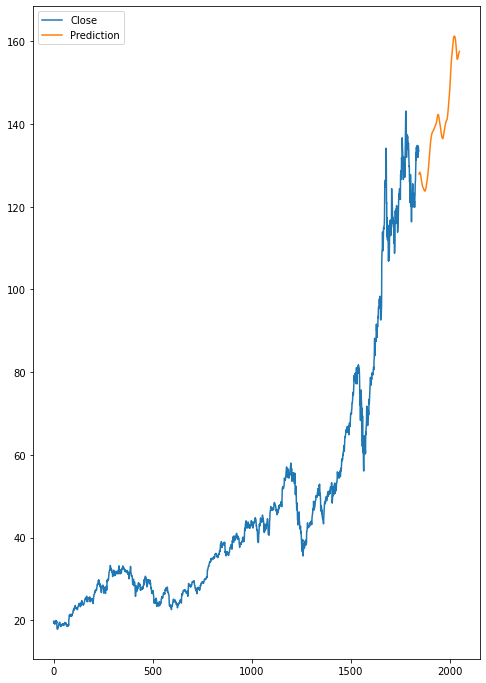

In [ ]:
ax = data_train.plot()

df_prediction.plot(ax = ax, figsize = (8,12))

### Visualize Prediciton and Compare Against Actual Close Price

<AxesSubplot:>

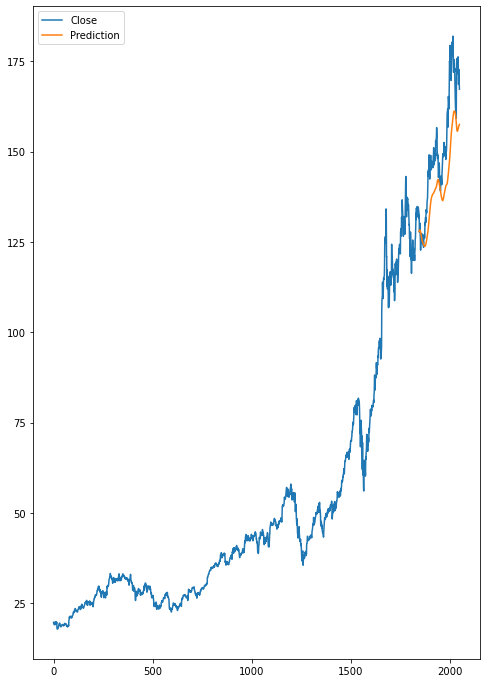

In [ ]:
ax = df.plot()
df_prediction.plot(ax = ax, figsize = (8,12))

# Timeseries Forecasting with LSTM

## Overview
##### Timeseries Forecasting:
##### --) Forecast into the "future" or unknown range
##### --) Should employ all the available data
##### --) i.e, NOT split the data into training/testing

## Preprocess Full Input Dataset

In [ ]:
# Still use MinMaxScaler to normalize the full input dataset df

full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

## Create Timeseries Generator for Forecasting

In [ ]:
# Number of time steps of the input time series
# Still use length60:
length60

60

In [ ]:
# Create timeseries Generator for forecasting

forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length = length60, batch_size = batch_size32)

## Build, Compile, and Fit LSTM Model for Forecasting

In [ ]:
# Train/Fit LSTM model
# In forecasting, we don't validate, only forecast
# so don't need earlystop or validation_generator

model.fit_generator(forecast_tsGenerator, epochs = 40)

Epoch 1/40
63/63 [==============================] - 29s 455ms/step - loss: 8.6819e-04
Epoch 2/40
63/63 [==============================] - 28s 449ms/step - loss: 0.0014
Epoch 3/40
63/63 [==============================] - 28s 444ms/step - loss: 9.3169e-04
Epoch 4/40
63/63 [==============================] - 29s 457ms/step - loss: 9.3509e-04
Epoch 5/40
63/63 [==============================] - 28s 447ms/step - loss: 0.0023
Epoch 6/40
63/63 [==============================] - 29s 460ms/step - loss: 0.0011
Epoch 7/40
63/63 [==============================] - 28s 448ms/step - loss: 0.0015
Epoch 8/40
63/63 [==============================] - 29s 465ms/step - loss: 0.0016
Epoch 9/40
63/63 [==============================] - 28s 445ms/step - loss: 8.3769e-04
Epoch 10/40
63/63 [==============================] - 29s 466ms/step - loss: 0.0010
Epoch 11/40
63/63 [==============================] - 29s 455ms/step - loss: 8.9019e-04
Epoch 12/40
63/63 [==============================] - 31s 487ms/step - loss: 

## Timeseries Forecast Using LSTM Neural Network: 02/19/2022 - 06/01/2022

In [ ]:
forecast = []

# Set periods with the time span of forecasting
# Let's forecast for the next 103 business days (02/19/2022 - 06/01/2022)
periods = 103

first_eval_batch = normalized_full_data[-length60:]
current_batch = first_eval_batch.reshape((1, length60, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to now include prediction and drop the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis = 1)

## Inverse to Transform Normalized Data Back into True Values

In [ ]:
forecast = full_scaler.inverse_transform(forecast)

forecast

array([[174.65891493],
       [174.56806361],
       [174.60110668],
       [174.74866057],
       [174.98574484],
       [175.28582327],
       [175.62664536],
       [175.99159663],
       [176.3693659 ],
       [176.75281032],
       [177.13772245],
       [177.52180289],
       [177.90402422],
       [178.28393635],
       [178.661461  ],
       [179.03668624],
       [179.40975884],
       [179.7807375 ],
       [180.14975922],
       [180.51692183],
       [180.88224491],
       [181.24575782],
       [181.60752904],
       [181.96754879],
       [182.32584643],
       [182.68242196],
       [183.03729494],
       [183.39046537],
       [183.7419724 ],
       [184.09179645],
       [184.43997667],
       [184.78653262],
       [185.13144473],
       [185.47475215],
       [185.8164353 ],
       [186.15655289],
       [186.49510492],
       [186.83207182],
       [187.16747317],
       [187.50136767],
       [187.83373574],
       [188.1645774 ],
       [188.49395134],
       [188

In [ ]:
df

,Close
0,19.754642
1,19.320715
2,19.426071
3,19.287144
4,19.409286
...,...
2044,168.880005
2045,172.789993
2046,172.550003
2047,168.880005


## Creating New Timestamp Index with Pandas: 02/19/2022 - 06/01/2022

In [ ]:
# Calculate forecast index

forecast_index = np.arange(2049, 2152, step = 1)

In [ ]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [ ]:
forecast_df

,Forecast
2049,174.658915
2050,174.568064
2051,174.601107
2052,174.748661
2053,174.985745
...,...
2147,201.299242
2148,201.449359
2149,201.597500
2150,201.743625


## Plot the Forecast

<AxesSubplot:>

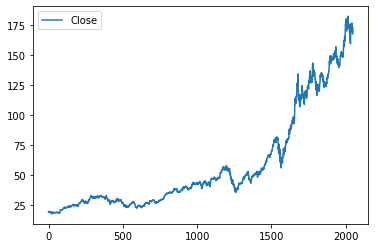

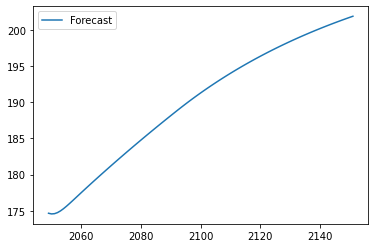

In [ ]:
df.plot()
forecast_df.plot()

## Joining Pandas Plots

<AxesSubplot:>

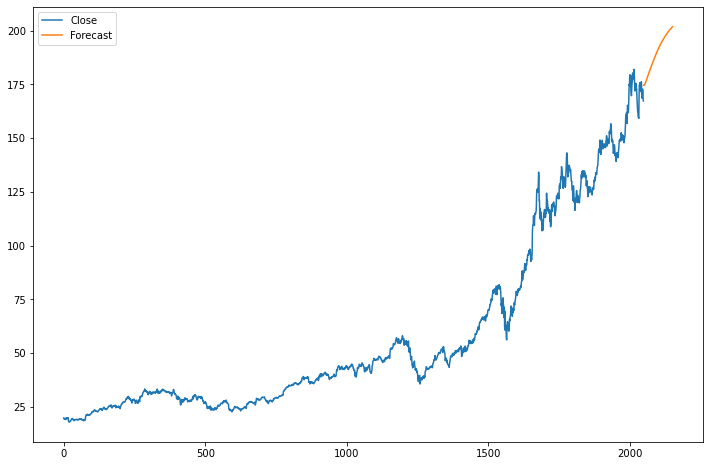

In [ ]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (12,8))

In [ ]:
# Homework directions did not specify to choose dates previous to current date
# so I was not able to plot the prediction against the true values as the values I predicted
# are actual future values.